In [47]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [48]:
# Set up the database connection
engine = create_engine("sqlite:///../reddit_posts.db")

In [44]:
# Read table
posts_df = pd.read_sql("posts_clean", engine)
posts_df.head()

,id,subreddit,title,selftext,date
0,c77jgf,investing,"Is ""The Big Short"" by Michael Lewis a good book?",I haven't read it yet.,2019-06-30
1,c78w4x,investing,Need help thinking through a long-term play on...,In the long run I am very bullish on renewable...,2019-06-30
2,c794e0,investing,Why chasing high yielding stocks is not the be...,[removed],2019-06-30
3,c796k7,investing,Auction.com Real Estate - Advice Needed!,[deleted],2019-06-30
4,c7994a,investing,Does anyone else think that Jim Rogers is righ...,He's predicting a more severe crash than 2008 ...,2019-06-30


In [45]:
comments_df = pd.read_sql("comments_clean", engine)
comments_df.head()

,id,subreddit,parent_id,body,date
0,esdguxz,geopolitics,None,Why none?,2019-06-30
1,esdhtud,geopolitics,None,&gt; Who is the realist?\n\nIt depends on what...,2019-06-30
2,esdi6lj,geopolitics,None,[removed],2019-06-30
3,esdi9eq,geopolitics,None,Vietnam is only a fraction of the size of Chin...,2019-06-30
4,esdilx8,geopolitics,None,"What is the ""West"" supposed to mean? The tradi...",2019-06-30


In [49]:
gold = pd.read_sql("gold", engine)
gold.head()

,date,Close,High,Low,Open,Volume
0,2019-06-27,1408.400024,1410.800049,1399.800049,1407.000000,437
1,2019-06-28,1409.699951,1422.000000,1408.300049,1408.300049,356
2,2019-07-01,1385.599976,1395.800049,1382.800049,1386.599976,214
3,2019-07-02,1404.599976,1418.400024,1390.800049,1391.099976,38
4,2019-07-03,1417.699951,1434.000000,1413.099976,1431.000000,46


In [26]:
# Import sentiment data
import matplotlib.pyplot as plt 
df_sent = pd.read_sql("posts_sentiment", engine, parse_dates=["date"])
print(df_sent.head())
print("\nLabel distribution:")
print(df_sent["label"].value_counts(), "\n")
print("Score stats:")
print(df_sent["score"].describe())

        id       date     label     score
0  1llbny8 2025-06-26  NEGATIVE  0.988981
1  1llbar3 2025-06-26  NEGATIVE  0.999304
2  1llauj7 2025-06-26  NEGATIVE  0.948334
3  1llan5e 2025-06-26  NEGATIVE  0.999715
4  1llaild 2025-06-26  NEGATIVE  0.995518

Label distribution:
label
NEGATIVE    234
POSITIVE     66
Name: count, dtype: int64 

Score stats:
count    300.000000
mean       0.960865
std        0.091394
min        0.510858
25%        0.978219
50%        0.994989
75%        0.998654
max        0.999846
Name: score, dtype: float64


In [27]:
# map POSITIVE→+score, NEGATIVE→–score
df_sent["signed_score"] = df_sent.apply(
    lambda r:  r["score"] if r["label"] == "POSITIVE" else -r["score"], axis=1
)

daily = (
    df_sent
      .groupby("date")
      .agg(
        post_count = ("id", "count"),
        avg_sent   = ("signed_score", "mean"),
        pos_ratio  = ("label", lambda s: (s=="POSITIVE").mean())
      )
      .reset_index()
)

# write back to SQL for easy reuse
daily.to_sql("daily_metrics", engine, if_exists="replace", index=False)
print(daily.tail())

         date  post_count  avg_sent  pos_ratio
27 2025-06-22           5 -0.993815   0.000000
28 2025-06-23           5 -0.996114   0.000000
29 2025-06-24          53 -0.361478   0.320755
30 2025-06-25          72 -0.432715   0.277778
31 2025-06-26          81 -0.504196   0.234568


In [28]:
window = 30

daily["vol_mean"] = daily["post_count"].rolling(window).mean()
daily["vol_std"]  = daily["post_count"].rolling(window).std()
daily["sent_mean"] = daily["avg_sent"].rolling(window).mean()
daily["sent_std"]  = daily["avg_sent"].rolling(window).std()

# volume spikes: post_count > mean + 2×std
daily["vol_spike"]  = daily["post_count"] > daily["vol_mean"] + 2 * daily["vol_std"]
# sentiment spikes: avg_sent > mean + 1.5×std or < mean – 1.5×std
daily["sent_spike"] = (
    (daily["avg_sent"] > daily["sent_mean"] + 1.5 * daily["sent_std"]) | (
    daily["avg_sent"] < daily["sent_mean"] - 1.5 * daily["sent_std"])
)

print(daily.loc[daily["vol_spike"] | daily["sent_spike"]])


         date  post_count  avg_sent  pos_ratio  vol_mean    vol_std  \
29 2025-06-24          53 -0.361478   0.320755  4.900000   9.263760   
30 2025-06-25          72 -0.432715   0.277778  7.266667  15.321685   
31 2025-06-26          81 -0.504196   0.234568  9.866667  20.361785   

    sent_mean  sent_std  vol_spike  sent_spike  
29  -0.750655  0.344964       True       False  
30  -0.732092  0.346642       True       False  
31  -0.715655  0.345320       True       False  


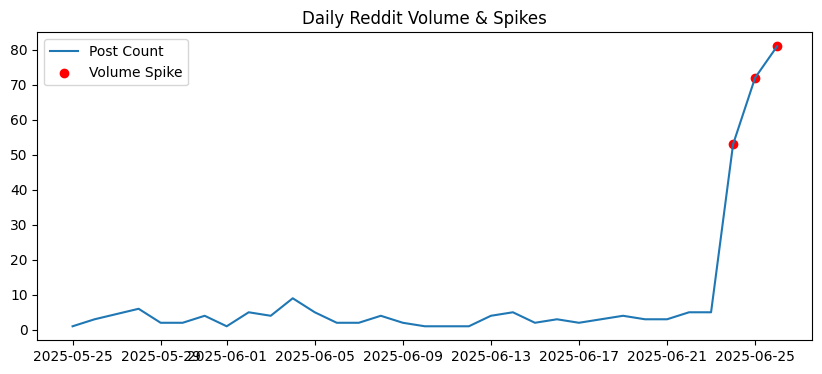

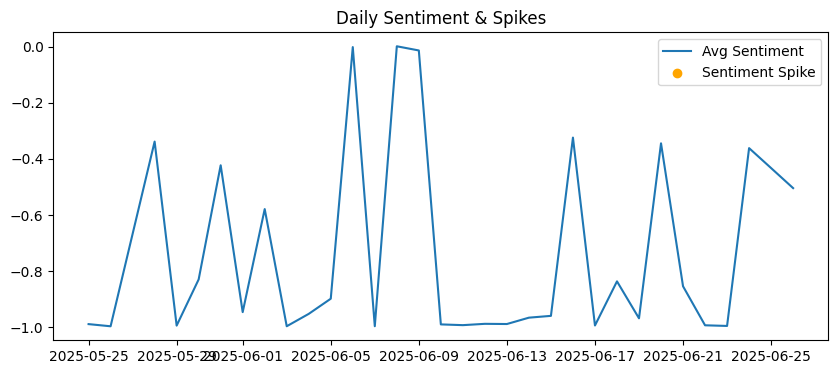

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(daily["date"], daily["post_count"], label="Post Count")
ax.scatter(daily["date"][daily["vol_spike"]],
           daily["post_count"][daily["vol_spike"]],
           color="red", label="Volume Spike")
ax.set_title("Daily Reddit Volume & Spikes")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(daily["date"], daily["avg_sent"], label="Avg Sentiment")
ax.scatter(daily["date"][daily["sent_spike"]],
           daily["avg_sent"][daily["sent_spike"]],
           color="orange", label="Sentiment Spike")
ax.set_title("Daily Sentiment & Spikes")
ax.legend()
plt.show()
